# Deployment of our Best Model using FastAPI.

In [1]:
%%writefile app.py

############################################################################################################################################################################
#                                                      Web application for MNIST Neural Netrowk Model using FastAPI 
############################################################################################################################################################################

# Libraries.
import logging
from logging.handlers import RotatingFileHandler
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from keras.models import load_model
from PIL import Image
import numpy as np
import io
import os

# Configure logging to both console and file.
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Create a file handler and set the log file name.
file_handler = RotatingFileHandler('app_logs.log', maxBytes=1024*1024, backupCount=3)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)


# Get the current working directory.
base_dir = os.path.dirname(os.path.abspath(__file__))

# Define the path to the model file relative to the current working directory.
model_path = os.path.join(base_dir, "Best_Model/model.h5")
# print(f"Model Path : {model_path}")
logger.info(f"Model Path : {model_path}")


# Load the saved model.
loaded_model = load_model(model_path)
# print("Model Loaded Successfully !!")
logger.info("Model Loaded Successfully !!")


# Initialize the FastAPI app.
app = FastAPI()
# print("FastAPI Initialized Successfully !!")
logger.info("FastAPI Initialized Successfully !!")

# Define a function to preprocess the image.
def preprocess_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize((28, 28))                       # Resize the image to match the model's input shape
    img_array = np.array(img)
    img_array = img_array[:, :, 0]                   # Convert to grayscale
    img_array = img_array.reshape((1, 28, 28, 1))    # Add batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values
    return img_array

# Define a route to accept image uploads and make predictions.
@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    try:
        # Read and preprocess the uploaded image.
        image_bytes = await file.read()
        img_array = preprocess_image(image_bytes)
        
        # Make a prediction using the loaded model.
        prediction = np.argmax(loaded_model.predict(img_array))
        
        # Log the prediction & return the prediction as JSON.
        logger.info(f"Prediction: {str(prediction)}")
        return JSONResponse(content={"prediction": str(prediction)}, status_code=200)
    
    except Exception as e:
    
        # Log the error and return an error message if prediction fails
        logger.error(f"Prediction failed: {e}")
        return JSONResponse(content={"error": str(e)}, status_code=500)

# Run the FastAPI app.
if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=8000)


################################## Command to run this app ######################################
    
# Open CMD & activate your virtual environment & then run the below command :=> 
#      uvicorn app:app --reload
    
#################################################################################################


Writing app.py


## Testing the deployed model.

### Starting the Uvicorn Server First.
### Go to CMD -> Type command -> ***uvicorn app:app --reload***

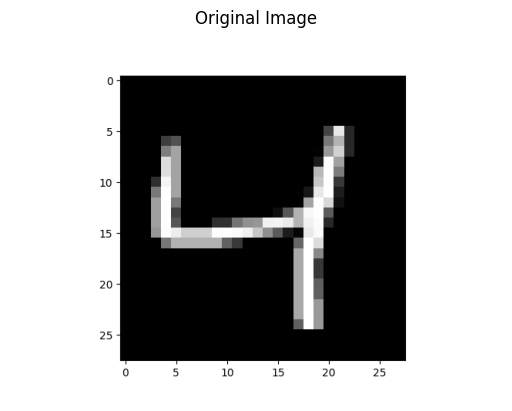

{"prediction":"4"}
Prediction From Model: 4


In [8]:
import requests
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


# Path to the image to test.
#image_path = "inference_images/3.png"  # Image of 1
image_path = "inference_images/2.png"  # Image of 4  

# Read the image
image = mpimg.imread(image_path)
# Show the image
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')  # Turn off axis numbers
plt.show()


##########  Testing the API Below ##########

# URL of your FastAPI server
url = "http://localhost:8000/predict/"

# Read the image file as binary
with open(image_path, "rb") as file:
    image_bytes = file.read()

# Send a POST request to the FastAPI server
response = requests.post(url, files={"file": image_bytes})

# Print the response
print(response.text)

# Parse the JSON response
response_json = json.loads(response.text)
prediction = response_json["prediction"]
print("Prediction From Model:", prediction)


In [3]:
!pip freeze > requirements.txt

'0.22.0'